## Estilização da Saída do Markdown

In [68]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulador de um Conversor Buck com CPL (Carga de Potência Constante)

## Descrição

Este notebook apresenta a implementação da modelagem matemática e do controlador de uma microrrede de corrente contínua, representada por um conversor buck com uma CPL (Carga de Potência Constante). O conversor buck é um dispositivo de conversão de potência que transforma uma tensão contínua de alta para baixa. A CPL é uma carga que demanda potência constante, independentemente da variação na tensão de entrada.

Para a implementação, serão utilizadas as bibliotecas Python Control, NumPy e Matplotlib. A modelagem matemática detalhada pode ser encontrada no documento separado chamado ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), localizado no diretório `docs`. Durante a implementação, serão explorados o sistema não linear, o sistema não linear transladado e o sistema linearizado, todos derivados da modelagem matemática.

### Data de Criação

2023-12-21

### Data de Modificação

2024-02-02

## Autor

Andevaldo da Encarnação Vitório  ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br))

## Orientador

Iury Valente de Bessa ([iury@ufam.edu.br](mailto:iury@ufam.edu.br))


## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

O código apresentado no início do tópico realiza a importação de diversas bibliotecas que serão utilizadas ao longo do desenvolvimento. Cada biblioteca possui um papel específico e contribui para o funcionamento do código:

- [`numpy`](https://numpy.org/): Biblioteca fundamental para manipulação de arrays e matrizes em Python. É utilizada para realizar cálculos matemáticos e operações com dados numéricos.
- [`matplotlib.pyplot`](https://matplotlib.org/): Biblioteca para criação de visualizações gráficas, como gráficos e diagramas. Permite a plotagem de dados e resultados de forma interativa e customizável.
- [`control`](https://python-control.readthedocs.io/): Biblioteca específica para análise e controle de sistemas dinâmicos. Fornece ferramentas para modelagem, simulação e análise de sistemas lineares e não lineares.

`ct.use_fbs_defaults()` define configurações padrão para o módulo `control`.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
ct.use_fbs_defaults()

In [70]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [71]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)

## 2. Descrição do Sistema e Circuito

O sistema a seguir foi projetado para simplificar a representação de uma microrrede, visando facilitar cálculos e análises. Composto por um conversor buck e uma CPL configurada como carga de potência constante, representada por uma fonte de corrente, o sistema oferece uma abordagem eficiente para modelar o comportamento da microrrede.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

No circuito apresentado:

- $R_L, \space R_C, \space C, \space L$: Resistores, capacitor e indutor do circuito.
- $d$: Duty Cycle
- $I_{CPL}$: Corrente da CPL
- $V_{in}$: Tensão de entrada.
- $V_{out}$: Tensão de entrada.

Neste circuito, $I_{CPL}$ depende da tensão do capacitor $v_C$ e da potência da CPL:

$$ I_{CPL} = \frac{P_{CPL}}{v_C}$$

## 3. Modelo Não-linear do Sistema
O modelo matemático adotado para o conversor buck baseia-se no modelo médio do sistema. Embora os conversores sejam naturalmente não-lineares, é comum empregar modelos de pequenos sinais (SSMs) para linearizar a representação em torno do ponto operacional (OP), considerando as situações de chave fechada e aberta.

### 3.1 Chave Fechada

Nesta configuração, a chave do conversor está fechada. O circuito é equivalente a um circuito série com uma fonte de tensão, um resistor e uma indutância. Durante este estado, as equações descrevem a variação da corrente $i_L$ no indutor e a tensão $v_C$ no capacitor.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit_m1.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave fechada é:

<br>

$$
\begin{equation}
  \tag{1.1} 
  M_{F}: \space
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

<br>

### 3.2 Chave Aberta

Na situação em que a chave está aberta, o circuito é desconectado da fonte de tensão.

<p align="center">
  <img src="../assets/imgs/main/buck_conversor_with_cpl_circuit_m2.svg" alt="Circuito Elétrico do Sistema" style="max-width:100%; height:260px;"/>
</p>

O modelo para a chave aberta é:

$$
\begin{equation}
  M_{A}: \space
  \tag{1.2} 
  \begin{cases}
    \frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
    \frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
  \end{cases}
\end{equation}
$$

### 3.3 Modelo Médio do Sistema

Baseado nas equações anteriores, o modelo médio do sistema é representado pelas equações diferenciais abaixo:

<br>

$$
\begin{equation}
MMS: \space
\tag{2} 
\begin{cases}
\frac{d}{dt}i_L &= \frac{V_{in}}{L} d - \frac{R_L}{L} i_L - \frac{1}{L} v_C \\ \\
\frac{d}{dt} v_C &= \frac{1}{C} i_L - \frac{1}{C R_C} v_C - \frac{1}{C v_C} P_{CPL}
\end{cases}
\end{equation}
$$

<br>


### 3.4 Implementação do Modelo Não-linear

#### 3.4.1 Definição de Funções de Atualização e Saída

Definição de uma função de atualização (para o lado direito da equação diferencial) e de uma função de saída (calcula as saídas a partir do estado)


In [72]:
def update_buck_nonlinear(t, x, u, params):
  # Parâmetros do sistema
  V_IN = params.get('Vin')  # Tensão de Entrada
  RL = params.get('rL')     # Resistência (indutor)
  RC = params.get('rC')     # Resistência (capacitor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância

  # Entradas do sistema: Duty Cycle e Potência da CPL
  D, P_CPL = u

  # Estados do sistema: corrente do indutor e tensão do capacitor
  IL, VC = x

  # Atualização da corrente do indutor
  diL = (V_IN / L) * D - (RL / L) * IL - VC / L

  # Atualização da tensão do capacitor
  dvC = IL / C - VC / (C * RC) - P_CPL / (C * VC)

  dx = np.array([diL, dvC])
  return dx

# Definição da saída do sistema


def output_buck_nonlinear(t, x, u, params):
  return x[0:2]


# Definição do conversor cc-cc buck nao-linear
buck_nonlinear = ct.ss(
    update_buck_nonlinear,
    output_buck_nonlinear,
    name='buck_nonlinear',
    inputs=('d', 'P_cpl'),
    outputs=('iL', 'vC'),
    states=('iL', 'vC')
)

## 4. Modelo Não-linear Trasladado

### 4.1 O Ponto de Operação

Ao adentrarmos no Modelo do Sistema Transladado, é importante primeiro definir as variáveis de estado e os valores de operação. Essas definições serão usadas para descrever o comportamento do sistema transladado.

Dada a condição de operação $P_O = \left( \overline{i_L}, \space \overline{V_C}, \space \overline{d}, \space \overline{P_{CPL}} \right) $, os estados e as entradas do sistema pode ser decompostos em termos fixos e em termos variantes no tempo.

<br>

$$
X: \space
\begin{cases}
  i_L(t) &= \overline{i_L} + \delta i_L(t) \\
  v_C(t) &= \overline{V_C} + \delta V_C(t) 
\end{cases}
, \space \space \space \space \space
U: \space
\begin{cases}
  d(t) &= \overline{d} + \delta d(t) \\
  P_{CPL}(t) &= \overline{P_{CPL}} + \delta P_{CPL}(t)
\end{cases}
$$

<br>

Além disto, as derivadas temporais das variáveis de estado também são representadas por:

<br>

$$
\dot{X}: \space
\begin{cases}
  \dot{i_L} &= \overline{\dot{i_L}} + \delta \dot{i_L} \\
  \dot{v_C} &= \overline{\dot{V_C}} + \delta \dot{V_C} 
\end{cases}
$$

<br>

Para a modelagem da dinâmica do sistema, são definidas as seguintes funções a partir da __Equação 3.3__:

<br>

$$
\begin{cases}
  f(i_L, \space v_C, \space d, \space P_{CPL}) = \dot{i_L} = - \frac{R_L}{L} i_L - \frac{1}{L} v_C + \frac{V_{in}}{L} d \\
  g(i_L, \space v_C, \space d, \space P_{CPL}) = \dot{v_C} = - \frac{1}{C R_C} v_C + \frac{1}{C} i_L - \frac{1}{C v_C} P_{CPL}
\end{cases}
$$

<br>

Importante notar que, sob condições de operação em regime permanente, as funções no ponto de operação são ambas nulas

<br>

$$ f(P_O) = g(P_O) = 0 $$

<br>

Além disto, os pontos fixos das derivadas temporais dos estado também são nulas:

<br>

$$ \overline{\dot{i_L}} = \overline{\dot{v_C}} = 0 $$

<br>

Com base nisso, é possível determinar o duty cycle $d$ e a corrente do indutor $i_L$ no ponto de operação utilizando a tensão do capacitor e a potência da CPL nesse ponto específico.

<br>

$$ 
\overline{i_L} = \frac{1}{R_C} \overline{v_C} + \frac{1}{\overline{v_C}} \overline{P_{CPL}}
\space , \hspace{1cm}
\overline{d} = \frac{R_L}{V_{in}} \overline{i_L} + \frac{\overline{v_C}}{V_{in}} 
\tag{4.1.1}
$$


<br>

### 4.2 Modelo Matemático

Portanto, o sistema transladado, considerando o ponto de operação $P_O = \left( \overline{i_L}, \space \overline{V_C}, \space \overline{d}, \space \overline{P_{CPL}} \right) $, é:

<br>

$$
\begin{equation}
M_{transladado}: \space
\tag{4.3} 
\begin{cases}
\delta \dot{i_L} &= - \displaystyle\frac{R_L}{L} \delta i_L - \displaystyle\frac{1}{L} \delta v_C  + \displaystyle\frac{V_{in}}{L} \delta d
\\ \\
\delta \dot{v_C} &= - \displaystyle\frac{1}{C R_C} \delta v_C  + \displaystyle\frac{1}{C}  \delta i_L + \displaystyle\frac{\overline{P_{CPL}} \delta v_C - \overline{v_C} \delta P_{CPL}}{C \overline{v_C} \left(\overline{v_C} + \delta v_C\right)} 
\end{cases}
\end{equation}
$$
<br>

### 4.3 Implementação do Modelo Não-linear Transladado

O código a seguir implementa o modelo não-linear transladado que descreve a dinâmica do sistema físico por meio da definição de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos, e a função de atualização `update_translated_nonlinear` contém as equações diferenciais que representam o comportamento dinâmico.

In [73]:
def update_translated_nonlinear(t, x, u, params):
  """
  Atualiza os estados do sistema não linear transladado.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - dx: derivadas dos estados do sistema
  """
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')
  RL = params.get('rL')
  RC = params.get('rC')
  L = params.get('L')
  C = params.get('C')
  OP = params.get('op')

  # Definição das entradas do sistema
  δD, δP_CPL = u

  # Definição dos estados do sistema
  δIL, δVC = x

  # Atualização
  DELTA_IL_DOT = - (RL / L) * δIL - δVC / L + (V_IN / L) * δD
  DELTA_VC_DOT = - δVC / (C * RC) + δIL / C + \
      (OP['Pcpl'] * δVC - OP['vC'] * δP_CPL) / \
      (C * OP['vC'] * (OP['vC'] + δVC))

  X_DOT = np.array([DELTA_IL_DOT, DELTA_VC_DOT])

  return X_DOT


def system_output(t, x, u, params):
  """
  Calcula a saída do sistema.

  Parâmetros:
  - t: tempo
  - x: estados do sistema
  - u: entradas do sistema
  - params: parâmetros do sistema

  Retorna:
  - y: saída do sistema
  """

  return x[:2]


translated_nonlinear_system = ct.NonlinearIOSystem(
    update_translated_nonlinear, system_output,
    name='translated_nonlinear_system',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

## 5. Simulação dos Modelos Não-lineares

#### 5.1 Definição dos Parâmetros da Simulação

 Especificação e atribuição dos valores iniciais aos parâmetros necessários para realizar a simulação do sistema.

In [74]:
def gen_u(timepts, values, D):
  U = np.zeros((2, len(timepts)))
  U[0, :] = D

  for i, t in enumerate(timepts):
    for j in range(len(values)-1):
      if values[j][0] <= t < values[j+1][0]:
        U[1, i] = values[j][1]
        break
    else:
      U[1, i] = values[-1][1]
  return U

In [75]:
# Parâmetros do Circuito

# params = {'Vin':  , 'rL': 0.1, 'rC': 10,
#           'L': 1e-3, 'C': 2.2e-3, 'op': {'Pcpl': 50, 'vC': 28}}

params = {'Vin': 48, 'rL': 0.1, 'rC': 20,
          'L': 1e-3, 'C': 2.2e-3, 'op': {'Pcpl': 250, 'vC': 28}}

# Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['vC'] / params['rC']) + op['Pcpl'] / op['vC']
D_OP = (params['rL'] * IL_OP) / params['Vin'] + op['vC'] / params['Vin']

params['op']['iL'] = IL_OP
params['op']['d'] = D_OP

# Ponto de operação de cada entrada e estado do sistema
U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
X_OP = np.array([params['op']['iL'], params['op']['vC']])

step = 1e-5
timepts = np.arange(0, .1 + step, step)

# Entradas do Sistema
D = params['op']['d']
P_CPL = params['op']['Pcpl']


# Variação 1
# values = [
#     (.0, 50),
#     (.1, 40),
#     (.2, 60),
#     (.3, 75),
#     (.4, 50),
#     (.5, 90),
#     (.6, 75),
#     (.7, 60),
#     (.8, 100),
#     (.9, 120),
# ]

# Variação 2
# values = [
# (.0, 100),
# (.1, 50),
# (.2, 150),
# (.3, 200),
# (.4, 250),
# (.5, 125),
# (.6, 150),
# (.7, 175),
# (.8, 225),
# (.9, 250),
# ]

values = [
    (0., 250)
]

U = gen_u(timepts, values, D)

# Estados Iniciais do Sistema
# IL_INIT = 1.5 * params['op']['iL']
# VC_INIT = 0.2 * params['op']['vC']

IL_INIT = .95 * params['op']['iL']
VC_INIT = .95 * params['op']['vC']
X0 = np.array([IL_INIT, VC_INIT])

δU = U - U_OP[:, np.newaxis]
δX0 = X0 - X_OP

print(δU)
print(δX0)

print('Parâmetros: ')
params

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-0.51642857 -1.4       ]
Parâmetros: 


{'Vin': 48,
 'rL': 0.1,
 'rC': 20,
 'L': 0.001,
 'C': 0.0022,
 'op': {'Pcpl': 250,
  'vC': 28,
  'iL': 10.32857142857143,
  'd': 0.6048511904761905}}

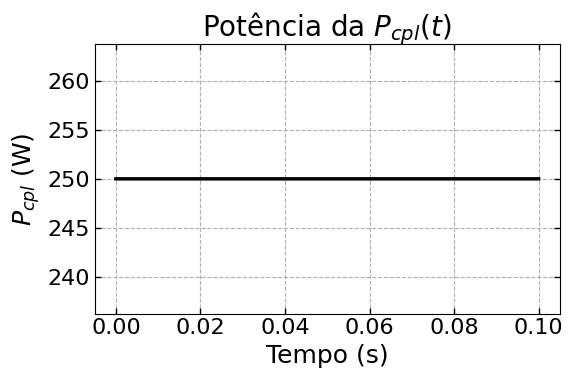

In [76]:
linewidth = 2.5

plt.figure(figsize=(6, 3.5))
plt.plot(timepts, U[1],
         linestyle='-', color='black', linewidth=linewidth, alpha=1)
# line3 = plt.axhline(y=params['op']['iL'], color='black',
#                        linestyle='-.', label='OP', linewidth=0.5)
plt.xlabel('Tempo (s)', fontsize=18)
plt.ylabel('$P_{cpl}$ (W)', fontsize=18)
plt.grid(linestyle='--')
plt.title('Potência da $P_{cpl}(t)$', fontsize=20)
plt.tick_params(axis='both', direction='in', length=4, width=1,
                colors='black', top=True, right=True, labelsize=16)

# plt.tight_layout()
plt.savefig(
    '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/buck/sim2_power_cpl_variation.eps', format='eps', bbox_inches='tight')

plt.show()

#### 5.2 Resposta do Sistema Não Linear

Implementação do sistema com um entrada e condições iniciais específicos a fim de obter o comportamento dinâmico do sistema não linear.

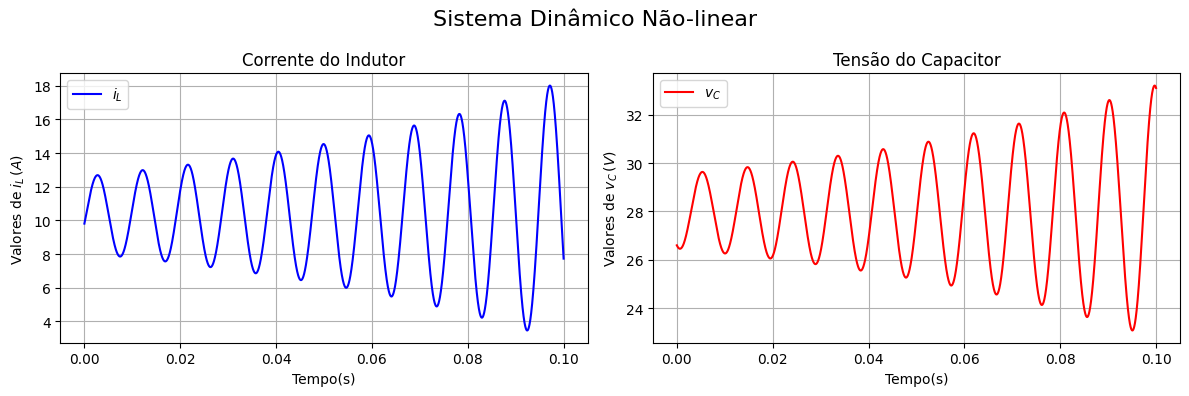

In [77]:
# Obtenção da saída
t, y_nonlinear = ct.input_output_response(
    sys=buck_nonlinear, T=timepts,
    U=U.tolist(),
    X0=X0.tolist(),
    params=params,
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()

### 5.3 Resposta do Sistema Não-linear Transladado

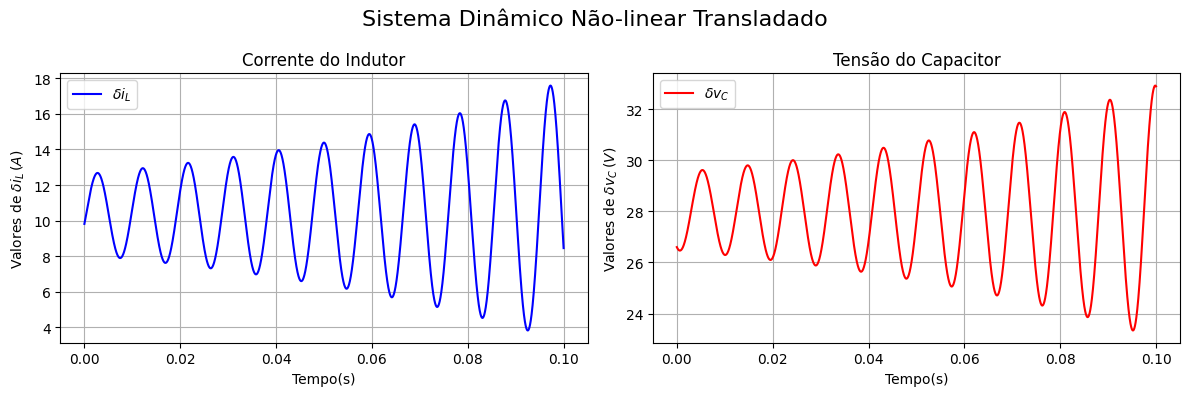

In [78]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_translated_nonlinear = ct.input_output_response(
    sys=translated_nonlinear_system, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
    params=params,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': 1e-4}
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_translated_nonlinear[0] + params['op']['iL'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_translated_nonlinear[1] + params['op']['vC'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear Transladado', fontsize=16)

plt.tight_layout()
plt.show()

## 6. Modelo do Sistema Linearizado

### 6.1 Descrição

O sistema linearizado, derivado a partir do sistema não linear, obtido na <a href="#section-3" style="color: #ffffff67; text-decoration: none;">Seção 3</a>, em torno dos pontos de operação, é representado por um conjunto de equações diferenciais lineares. Essas equações descrevem as variações no tempo das grandezas $\delta i_L$ e $\delta v_C$, que representam as alterações na corrente do indutor e na tensão do capacitor, respectivamente.

Baseado nisto, o sistema linearizado terá a forma:

$$
  \begin{cases}
    \frac{d}{dt} (\delta i_L) &= k_1 \cdot \delta i_L + k_2 \cdot \delta v_C + k_3 \cdot \delta d + k_4 \cdot \delta P_{CPL} \\ \\
    \frac{d}{dt} (\delta v_C) &= k_5 \cdot \delta i_L + k_6 \cdot \delta v_C + k_7 \cdot \delta d + k_8 \cdot \delta P_{CPL}
  \end{cases}
$$

Considerando as seguintes funções a seguir,

$$f(P) = \frac{d}{dt}i_L, \space\space\space\space  g(P) = \frac{d}{dt}v_C$$

onde $P = (i_L, \space v_C, \space d, \space P_{CPL})$, podemos obter os coeficientes $k$ com as seguintes derivadas parciais:
  
$$
k_1 = \dfrac{\partial f}{\partial i_L} \vert_{P = P_O}, \space \space
k_2 = \dfrac{\partial f}{\partial v_C} \vert_{P = P_O}, \space \space
k_3 = \dfrac{\partial f}{\partial d} \vert_{P = P_O}, \space \space
k_4 = \dfrac{\partial f}{\partial P_{CPL}} \vert_{P = P_O}
$$

$$
k_5 = \dfrac{\partial g}{\partial i_L} \vert_{P = P_O}, \space \space
k_6 = \dfrac{\partial g}{\partial v_C} \vert_{P = P_O}, \space \space
k_7 = \dfrac{\partial g}{\partial d} \vert_{P = P_O}, \space \space
k_8 = \dfrac{\partial g}{\partial P_{CPL}} \vert_{P = P_O}
$$

<br>

onde $P_O = (\overline{i_L}, \space \overline{v_C}, \space \overline{d}, \space \overline{P_{CPL}})$, é o ponto de operação definido na <a href="#section-4" style="color: #ffffff67; text-decoration: none;">Seção 4</a>. Desta forma, os termos são:

<br>

$$
k_1 = - \frac{R_L}{L}, \space\space\space\space
k_2 = - \frac{1}{L}, \space\space\space\space
k_3 = \frac{V_{in}}{L} , \space\space\space\space
k_4 = 0
$$

$$
k_5 = \frac{1}{C}, \space\space\space\space
k_6 = \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{{\overline{v_{C}}}^2}} - \frac{1}{R_C}\right), \space\space\space\space
k_7 = 0, \space\space\space\space
k_8 = - \frac{1}{C \overline{v_C}}
$$

<br>

Portanto, o sistema linearizado é:

<br>

$$
\begin{equation}
\tag{5.1}
  \begin{cases}
    \displaystyle \frac{d}{dt} (\delta i_L) &= \displaystyle - \frac{R_L}{L} \delta i_L - \frac{1}{L} \delta v_C + \frac{V_{in}}{L} \delta d 
    \\ \\
    \displaystyle  \frac{d}{dt} (\delta v_C) &= \displaystyle \frac{1}{C} \delta i_L + \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{\overline{{v_{C}}}^2}} - \frac{1}{R_C}\right) \delta v_C - \frac{1}{C \overline{v_C}} \delta P_{CPL}
  \end{cases}
\end{equation}
$$

ou,

$$
  \begin{bmatrix}
    \dot{\delta i_L} \\ \dot{\delta v_C}
  \end{bmatrix}
  =
  \begin{bmatrix}
    \displaystyle -\frac{R_L}{L} & \displaystyle -\frac{1}{L} \\ \\
    \displaystyle \frac{1}{C} & \displaystyle \frac{1}{C}\left(\frac{\overline{P_{CPL}}}{{{\overline{v_{C}}}^2}} - \frac{1}{R_C}\right)
  \end{bmatrix}
  \begin{bmatrix}
    \delta i_L \\ \delta v_C
  \end{bmatrix}
  +
  \begin{bmatrix}
    \displaystyle{\frac{V_{in}}{L}} & 0 \\ \\ 
    0 & \displaystyle{-\frac{1}{C\overline{v_C}}}
  \end{bmatrix}
  \begin{bmatrix}
    \delta d \\ \delta P_{CPL}
  \end{bmatrix}
$$

<br>

### 6.2 Implementação do Sistema Linearizado

O código a seguir implementa o modelo linearizado em torno de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos.

In [79]:
# Obtenção dos valores no ponto de operação (OP)
OP = params['op']

# Elementos da matriz de estados
A11 = - (params['rL'] / params['L'])
A12 = - (1. / params['L'])
A21 = 1. / params['C']
A22 = (1. / params['C']) * (OP['Pcpl'] /
                            (OP['vC'] * OP['vC']) - 1. / params['rC'])

# Elementos da matriz de entrada
B11 = params['Vin'] / params['L']
B12 = 0.
B21 = 0.
B22 = - 1.0 / (params['C'] * OP['vC'])

# Matriz de estados: iL e vC
A = [[A11, A12], [A21, A22]]

# Matriz de entradas: d e P_cpl
B = [[B11, B12], [B21, B22]]

# Matriz de saída: iL e vC
C = [[1., 0], [0., 1]]

# Matriz de alimentação: nula
D = [[0., 0.], [0., 0.]]

buck_linearized = ct.ss2io(
    ss(A, B, C, D),
    name='buck_linearized',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

### 6.3 Simulação do Sistema Linearizado

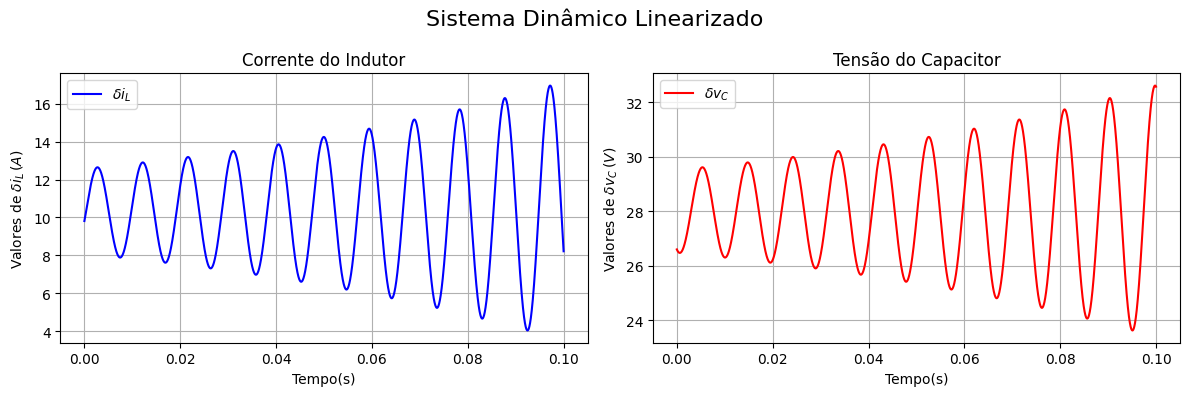

In [80]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_linear = ct.input_output_response(
    sys=buck_linearized, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_linear[0] + OP['iL'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_linear[1] + OP['vC'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Linearizado', fontsize=16)

plt.tight_layout()
plt.show()

#### 7. Comparação dos Resultados Obtidos na Simulação

Nesta seção, exploramos visualmente o comportamento do sistema através de gráficos. A biblioteca Matplotlib é utilizada para criar visualizações que representam a resposta do sistema ao longo do tempo.

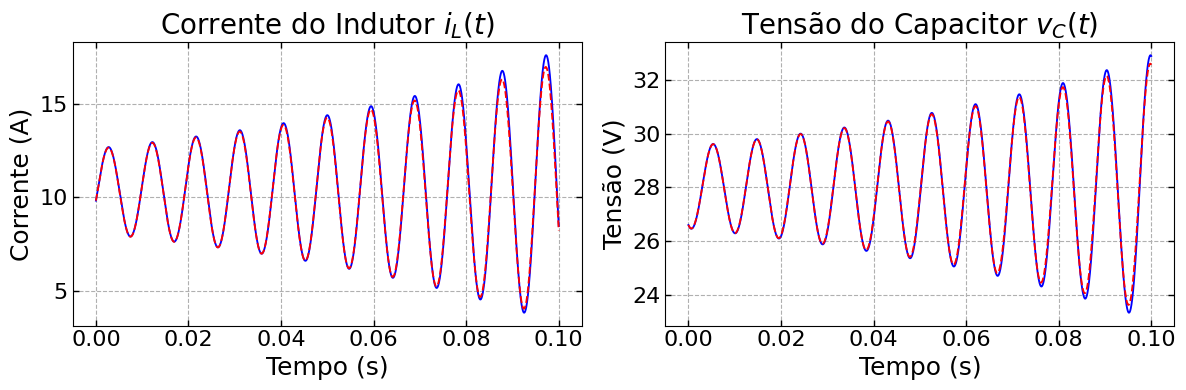

In [81]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

linewidth = 1.33

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_translated_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='b', linewidth=linewidth, alpha=1)

line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='--',
                     color='r', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_translated_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='b', label='Não linear Transladado', linewidth=linewidth)

axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='--',
            color='r', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
# fig.legend([line1, line2], ['Não Linear Transladado', 'Linearizado'],
#            fontsize=18, loc='upper center', bbox_to_anchor=(.5, 0.0), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# plt.savefig(
#     '/home/andel/Projetos/Latex/[TCC] Andevaldo Vitório/figuras/buck/sim2_op2_nonlinear.eps', format='eps', bbox_inches='tight')

## 7. Implementação dos ETM Estático e Dinâmico

Nesta seção, apresentamos o modelo de ETM dinâmico e estático proposto por Coutinho, que será utilizado neste projeto. Este modelo se baseia em uma condição suficiente para permitir o projeto simultâneo do ETM e do controlador com ganhos escalonados, garantindo a estabilidade assintótica da origem do sistema em malha fechada. Além disso, aborda um problema de otimização visando a ampliação dos intervalos entre eventos, com o objetivo de minimizar a quantidade de eventos gerados pelo ETM.

In [82]:
# Definição dos parâmetros do problema de otimização
A = cp.Parameter((2, 2),
                 value=np.array([[A11, A12], [A21, A22]]))
BU = cp.Parameter((2, 1), value=np.array([[B11], [B12]]))
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Definição das variáveis do problema de otimização
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
Q = cp.Variable((2, 2), name='Q', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

# Definição do problema: objetivo e restrições
obj = cp.Minimize(cp.trace(Ξ_TIL + Ψ_TIL))

M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

N11 = -Q
N12 = I
N21 = I
N22 = -X
N = cp.bmat([[N11, N12],
             [N21, N22]])

print(M.shape)
constraints = [M << 0]
prob = cp.Problem(obj, constraints)

# Resolução do problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K = None
Ξ = None
Ψ = None
P = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)
  P = X_INV

  show_matrix('P', P)
  show_matrix('Ξ', Ξ),
  show_matrix('Ψ', Ψ),
else:
  print('O problema não é factível')

(6, 6)
Valor ótimo: 3.778748927656879e-11

Ξ_TIL =
    ┌                     ┐
    │ 6.53e-10   2.32e-10 │
    │ 2.32e-10  -1.75e-10 │
    └                     ┘

Ψ_TIL =
    ┌                      ┐
    │ -2.34e-10   8.44e-12 │
    │  8.44e-12  -2.05e-10 │
    └                      ┘

X =
    ┌                      ┐
    │ -4.79e-10   5.95e-11 │
    │  5.95e-11  -2.20e-10 │
    └                      ┘

K_TIL =
    ┌                      ┐
    │ -1.45e-13  -3.79e-14 │
    └                      ┘

K =
    ┌                    ┐
    │ 3.35e-04  2.63e-04 │
    └                    ┘

P =
    ┌                      ┐
    │ -2.16e+09  -5.84e+08 │
    │ -5.84e+08  -4.71e+09 │
    └                      ┘

Ξ =
    ┌                     ┐
    │ 3.57e+09   2.78e+09 │
    │ 2.78e+09  -2.39e+09 │
    └                     ┘

Ψ =
    ┌                      ┐
    │ -4.27e+09  -1.76e+08 │
    │ -1.76e+08  -4.88e+09 │
    └                      ┘




### 7.1 ETM Dinâmico

O modelo proposto por Coutinho para o ETM dinâmico considera uma classe específica de sistemas não lineares, representada pela equação abaixo:

$$ \dot{x}(t) = A(x(t))x(t) + B(x(t))u(t) $$

Nesta equação, $ x(t) \in D \subset \mathbb{R}^n $ representa o estado do sistema, $ u(t) \in \mathbb{R}^m $ é a entrada de controle, e $ A: D \rightarrow \mathbb{R}^{n \times n} $ e $ B: D \rightarrow \mathbb{R}^{n \times m} $ são funções contínuas de matriz, com a restrição de que $ B(x) \neq 0 $ para todo $ x \in D $. Os termos não lineares nos coeficientes dependentes do estado, $ A(x) $ e $ B(x) $, são representados por $ z*j: D \rightarrow \mathbb{R} $, onde $ j \in \mathbb{N}*{\leq p} $, e são denominados funções de programação. Aqui, $ D \subset \mathbb{R}^n $ é um politopo convexo que inclui a origem, sendo esta considerada o ponto de equilíbrio de interesse.

O tempo de ocorrência dos eventos é determinado pela seguinte equação:

$$ t_0 = 0, t_{k+1} = \inf \{t > t_k : \eta(t) + \theta \Gamma(x(t), e(t) < 0) \}, \, \forall k \in \N$$

Onde $\theta \in \mathbb{R}_{\geq 0}$ é um parâmetro de projeto e a função de acionamento $\Gamma(x, e)$ é definida como:

$$ \Gamma(x, e) = x^T \Psi x - e^T \Xi e - \zeta (x,e) $$

com

$$ \zeta(x, e) = 2x^TPB(x)(K(\hat{x}) - K(x))(x+e)$$

A dinâmica da variável interna do ETM é definida como:

$$ \dot{\eta} = - \lambda \eta(t) + \Gamma(x(t), e(t)) $$

onde $\lambda \in R_{\geq} 0 $ é o parâmetro de projeto relacionado à taxa de decaimento de $\eta(t)$.

### Modelo de ETM Dinâmico Proposto

In [83]:
zero = 0
event_times = [0.]


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error


def etm_output(t, x, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.ss(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.last_states_sent = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (buck_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('buck_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'buck_linearized.δiL'),
        ('etm.x2', 'buck_linearized.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed_loop_buck_system',
    inplist=('buck_linearized.δPcpl'),
    outlist=('buck_linearized.δiL',
             'buck_linearized.δvC',
             'buck_linearized.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

print(CLOSED_LOOP_BUCK_SYSTEM)
print('')

δPcpl = δU[1]

t, y = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

<InterconnectedSystem>: closed_loop_buck_system
Inputs (1): ['u[0]']
Outputs (3): ['δiL', 'δvC', 'u']
States (2): ['buck_linearized_δiL', 'buck_linearized_δvC']



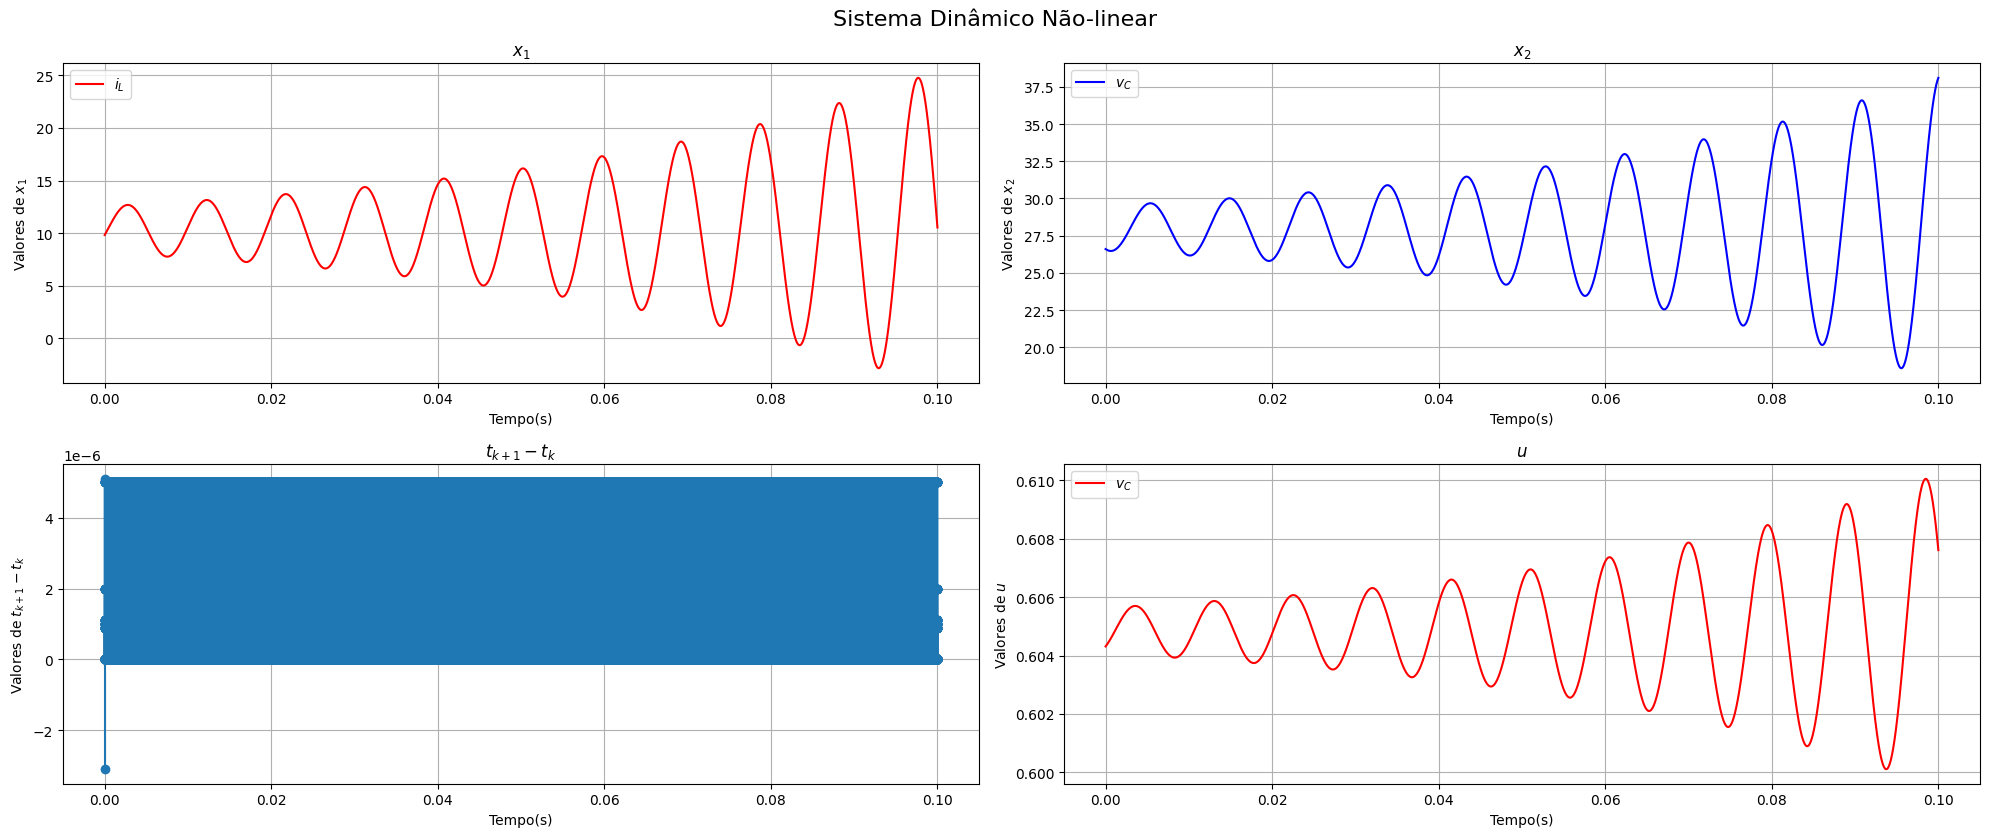

In [84]:
tk_time = []
tk_value = []

# last_triggered_time = None
# for i in range(len(t)):
#   if y[2][i]:
#     if last_triggered_time is not None:
#       tk_time.append(last_triggered_time)
#       tk_value.append(t[i] - last_triggered_time)
#     last_triggered_time = t[i]

# print(tk_value)

for i in range(1, len(event_times)):
  tk_time.append(event_times[i])
  tk_value.append(event_times[i] - event_times[i-1])

fig, axs = plt.subplots(2, 2, figsize=(20, 8.5))

# Gráfico 1
axs[0][0].plot(t, y[0] + OP['iL'], linestyle='-', color='r', label='$i_L$')
axs[0][0].set_xlabel('Tempo(s)')
axs[0][0].set_ylabel('Valores de $x_1$')
axs[0][0].set_title('$x_1$')
axs[0][0].legend()
axs[0][0].grid(True)

# Gráfico 2
axs[0][1].plot(t, y[1] + OP['vC'], linestyle='-', color='b', label='$v_C$')
axs[0][1].set_xlabel('Tempo(s)')
axs[0][1].set_ylabel('Valores de $x_2$')
axs[0][1].set_title('$x_2$')
axs[0][1].legend()
axs[0][1].grid(True)

# Gráfico 3
if len(event_times) > 1:
  axs[1][0].stem(tk_time, tk_value, basefmt=' ')
  axs[1][0].set_xlabel('Tempo(s)')
  axs[1][0].set_ylabel('Valores de $t_{k+1}-t_k$')
  axs[1][0].set_title('$t_{k+1}-t_k$')
  axs[1][0].grid(True)


# Gráfico 4
axs[1][1].plot(t[1:], y[2][1:] + OP['d'],
               linestyle='-', color='r', label='$v_C$')
axs[1][1].set_xlabel('Tempo(s)')
axs[1][1].set_ylabel('Valores de $u$')
axs[1][1].set_title('$u$')
axs[1][1].legend()
axs[1][1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()